In [1]:
import glob
import json
import math
import os
import random
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

input_dir = "/app/dataset/preprocess/exp2"
output_dir = "./output"
os.makedirs(output_dir, exist_ok=True)

### 1. Data preprocessing
+ 1.1 observation and cleaning (done)
+ 1.2 splitting
+ 1.3 numpy or dataloader

In [2]:
# load data
dataset = np.load(f"{input_dir}/dataset.npy", allow_pickle=True)
num_samples, window_size, total_features = dataset.shape
print(dataset.shape)  # (num_samples, window_size, total_features)

meta_list = json.load(open(f"{input_dir}/meta.json", "r"))
print(len(meta_list), meta_list[0])  # (nums_samples, {...})

price_ratio = np.load(f"{input_dir}/price_ratio.npy", allow_pickle=True)
num_samples, num_tickers_add1, pred_days_minus1 = price_ratio.shape
num_tickers = num_tickers_add1 - 1
pred_days = pred_days_minus1 + 1
print(price_ratio.shape)  # (num_samples, num_tickers + 1, pred_days - 1)

(2336, 84, 75)
2336 {'date_start': '2019-01-03 00:00:00', 'date_end': '2019-03-28 00:00:00', 'pred_end': '2019-04-25 00:00:00', 'top_tickers': ['ETH', 'XRP', 'EOS', 'BCH', 'LTC', 'XLM', 'BNB', 'TRX', 'ADA', 'IOTA', 'XMR', 'DASH', 'NEO', 'MKR', 'ETC']}
(2336, 16, 29)


In [3]:
# splitting
seed = 7
random.seed(seed)

n_train = int(num_samples * 0.8)
train_indices = list(range(num_samples))[:n_train]
valid_indices = list(range(num_samples))[n_train:]
random.shuffle(train_indices)

train_dataset = dataset[train_indices]
valid_dataset = dataset[valid_indices]
train_price_ratio = price_ratio[train_indices]
valid_price_ratio = price_ratio[valid_indices]
print(train_dataset.shape, valid_dataset.shape)  # (n_train, window_size, features) (n_valid, window_size, features)
print(train_price_ratio.shape, valid_price_ratio.shape)  # (n_train, n_ticks+1, pdays-1) (n_valid, n_ticks+1, pdays-1)

(1868, 84, 75) (468, 84, 75)
(1868, 16, 29) (468, 16, 29)


In [4]:
class ToyTimeSeriesRegressionDataset(Dataset):
    def __init__(self, x: np.ndarray, y: np.ndarray):
        """
        Args:
            x (np.ndarray): shape = (num_data, window_size, num_input_features)
            y (torch.Tensor): shape = (num_data, n_ticks+1, pdays-1)
        """
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self) -> int:
        return len(self.x)
    
    def __getitem__(self, index) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returns:
            x (torch.Tensor): shape = (window_size, num_input_features)
            y (torch.Tensor): shape = (n_ticks+1, pdays-1)
        """
        return self.x[index], self.y[index]


trainset = ToyTimeSeriesRegressionDataset(train_dataset, train_price_ratio)
validset = ToyTimeSeriesRegressionDataset(valid_dataset, valid_price_ratio)
trainset[0][0].shape, trainset[0][1].shape  # (window_size, num_input_features), (num_output_features,)

(torch.Size([84, 75]), torch.Size([16, 29]))

In [5]:
batch_size = 1

trainloader = DataLoader(trainset, batch_size=batch_size, pin_memory=False, shuffle=False)
validloader = DataLoader(validset, batch_size=batch_size, pin_memory=False, shuffle=False)

### 2. Model prepatation
+ 2.1 model
+ 2.2 loss
+ 2.3 more hyperparameters

In [6]:
# model

model_name = "LSTM"
#model_name = "Transformer"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [7]:
class ToyTimeSeriesRegressionLSTM(torch.nn.Module):
    def __init__(
            self,
            window_size: int,
            num_input_features: int,
            num_output_features: int,
            hidden_size: int = 64
        ):
        super().__init__()
        self.lstm = torch.nn.LSTM(
            input_size = num_input_features,
            hidden_size = hidden_size,
            num_layers = 3,
            batch_first = True,
        )
        self.flatten = torch.nn.Flatten(start_dim = 1)
        self.dense = torch.nn.Linear(hidden_size * window_size, num_output_features)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (torch.Tensor): shape=(batch_size, window_size, num_input_features)
        Returns:
            x (torch.Tensor): shape=(batch_size, num_output_features)
        """
        x, (_, _) = self.lstm(x)  # shape = (batch_size, window_size, hidden_size)
        x = self.flatten(x)  # shaoe = (batch_size, window_size * hidden_size)
        x = self.dense(x)
        return x
    

if model_name == "LSTM":
    example_x, example_y = next(iter(trainset))
    window_size, num_input_features = example_x.shape 
    num_output_features = example_y.numel() + num_tickers_add1
    model = ToyTimeSeriesRegressionLSTM(
            window_size,
            num_input_features,
            num_output_features,
            hidden_size = 32
        ).to(device)
    print(model)
    print("num_parameters:", sum(p.numel() for p in model.parameters()))
    print(model(example_x.reshape(-1, window_size, num_input_features)).shape)

ToyTimeSeriesRegressionLSTM(
  (lstm): LSTM(75, 32, num_layers=3, batch_first=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense): Linear(in_features=2688, out_features=480, bias=True)
)
num_parameters: 1321568
torch.Size([1, 480])


In [8]:
# class PositionalEncoding(torch.nn.Module):
#     """
#     PE(pos, i)
#         where pos = 0, 1, 2, ..., window_size - 1
#         and i = 0, 1, 2, ..., num_input_features - 1
    
#     for i = even -> sin(pos / 10000 ** (2 * i / num_input_features))
#     for i = odd  -> cos(pos / 10000 ** (2 * i / num_input_features))

#     Notes:
#         + window_size = content length = sequence length
#         + num_input_features = d_model = encoding size = embedding size
#     """
#     def __init__(self, num_input_features: int, max_len: int = 5000):
#         """
#         max_len has same axis as window_size. that means it supports all window_size within 1~5000.
#         """
#         super().__init__()
#         position = torch.arange(max_len).unsqueeze(1)   # shape = (max_len, 1). i.e. [[0],[1],[2],...,[5000]]
#         div_term = torch.exp(torch.arange(0, num_input_features, 2) * (-math.log(10000.0) / num_input_features))
#         # div_term (divisor_term): shape = (num_features // 2,)
#         # e.g. torch.arange(0, num_input_features=4, 2) = [0, 2]
#         # e.g. div_term = exp([0, 2] * (-log(10000) / 4))
#         # = [exp(-0 / 4 * log(10000)), exp(-2 / 4 * log(10000))]
#         # = [10000 ** -0 / 4, 10000 ** -2 / 4]
#         # = [1 / 10000 ** 0 / 4, 1 / 10000 ** 2 / 4]
        
#         pe = torch.zeros(max_len, num_input_features)
#         pe[:, 0::2] = torch.sin(position * div_term)   # shape = (max_len, num_input_features) = (5000, 4)
#         pe[:, 1::2] = torch.cos(position * div_term)   # shape = (max_len, num_input_features) = (5000, 4)
        
#         self.register_buffer('pe', pe)  # remain at cpu and non-trainable
    

#     def forward(self, x):
#         """
#         Args:
#             x (torch.Tensor): shape = (batch_size, window_size, features)
#         Returns:
#             x (torch.Tensor): same shape as above
#         """
#         window_size = x.shape[1]
#         return x + self.pe[:window_size, :].unsqueeze(0)


# class ToyTransformerEncoder(torch.nn.Module):
#     def __init__(self, window_size: int, num_input_features: int, num_output_features: int):
#         super().__init__()
#         self.positional_encoding = PositionalEncoding(num_input_features)
#         encoder_layer = torch.nn.TransformerEncoderLayer(
#             d_model = num_input_features,
#             nhead = 2,
#             dim_feedforward = 64,
#             batch_first = True
#         )
#         self.transformer_encoder = torch.nn.TransformerEncoder(encoder_layer, num_layers=3)
#         self.flatten = torch.nn.Flatten(start_dim = 1)
#         self.dense = torch.nn.Linear(num_input_features * window_size, num_output_features)

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         """
#         Args:
#             x (torch.Tensor): shape = (batch_size, window_size, num_input_features)
#         Returns:
#             x (torch.Tensor): shape = (batch_size, num_output_features)
#         """
#         x = self.positional_encoding(x)
#         x = self.transformer_encoder(x)
#         x = self.flatten(x)
#         x = self.dense(x)
#         return x


# if model_name == "Transformer":
#     example_x, example_y = next(iter(trainset))
#     window_size, num_input_features = example_x.shape 
#     num_output_features = example_y.numel()
#     model = ToyTransformerEncoder(
#         window_size,
#         num_input_features,
#         num_output_features
#     ).to(device)
#     print(model)
#     print("num_parameters:", sum(p.numel() for p in model.parameters()))
#     print(model(example_x).shape)

In [9]:
class SharpeLoss(torch.nn.Module):
    def __init__(
            self,
            transaction_fee_rate: float = 0.0002,
            pred_days: int = 30,
            num_tickers: int = 16,
            ema_alpha: float = 0.1,
            history_save_path: str = "",
            history_save_freq: int = 100
        ):
        super().__init__()
        self.transaction_fee_rate = transaction_fee_rate
        self.pred_days = pred_days
        self.num_tickers = num_tickers
        self.ema_alpha = ema_alpha
        self.history_save_path = history_save_path
        if self.history_save_path:
            os.makedirs(os.path.dirname(self.history_save_path), exist_ok=True)
            self.train_history, self.train_history_acc = [], 0
            self.history_save_freq = history_save_freq
        self.i = 0
    
    def forward(self, y_pred, y_true):
        model_output = y_pred.reshape(self.pred_days, self.num_tickers)  # (30, 16)
        price_ratio_block = y_true.reshape(self.num_tickers, self.pred_days - 1)  # (16, 29)
        if model_output.isnan().any():
            print("model output has nan", self.i)
            print(pd.DataFrame(model_output.detach().cpu().numpy()))
            raise

        # change the last column (cash) to be non-negative
        # init investment combination for days
        comb_for_days = model_output / model_output.sum(axis=1, keepdim=True)
        comb_for_days = torch.cat([
            comb_for_days[:, :-1],
            torch.abs(comb_for_days[:, -1:])
        ], dim=1)
        comb_for_days = comb_for_days / comb_for_days.sum(axis=1, keepdim=True)

        # iterate days for changing
        money_comb = comb_for_days[0].clone()
        money_history = [torch.tensor(1.0, device=y_pred.device)]
        for day in range(1, self.pred_days):
            # iterate tickers in a day
            money_comb = money_comb * (1 + price_ratio_block[:, day - 1])
            turnover = torch.abs(comb_for_days[day] - comb_for_days[day - 1]).sum()
            money = money_comb.sum()
            #money = torch.clamp(money - money * turnover * self.transaction_fee_rate, min=1e-12)
            money = money - money * turnover * self.transaction_fee_rate
            money_history.append(money)
            money_comb = comb_for_days[day] * money  # reweighting
            #print(day, float(money_history[-1]), [x.item() for x in money_comb])
            #print("===")
            if money_comb.isnan().any():
                print("combination has nan", self.i)
                print(pd.DataFrame(model_output.detach().cpu().numpy()))
                print(money_comb)
                raise
        money_history = torch.stack(money_history)

        # compute sharpe ratio
        if self.history_save_path:
            excess_returns = money_history[1:] / money_history[:-1] - 1
            sharpe_ratio = excess_returns.mean() / (excess_returns.std() + 1e-6)
            self.train_history_acc += float(sharpe_ratio.item())
            if (self.i + 1) % self.history_save_freq == 0:
                self.train_history.append(self.train_history_acc / self.history_save_freq)
                self.train_history_acc = 0
                self.save_history()

        # compute log return with EMA  # alpha has include 1/(1+days) already  # r**2 is ele in variance
        log_returns = torch.log(money_history[1:] / (money_history[:-1] + 1e-10) + 1e-10)
        if 1:
            mask = ~torch.isnan(log_returns)
            # compute mean over valid entries
            mean_val = log_returns[mask].mean()
            # replace NaN with mean
            log_returns = torch.where(mask, log_returns, mean_val)
        ema_var = torch.zeros(1, device=y_pred.device)
        for r in log_returns:
            ema_var = self.ema_alpha * (r ** 2) + (1 - self.ema_alpha) * ema_var
        ema_std = torch.sqrt(ema_var + 1e-8)

        # Sharpe ratio
        sharpe_ratio = log_returns.mean() / (ema_std + 1e-6)

        if sharpe_ratio.isnan().any():
            print("sharpe ratio has nan", self.i)
            print(pd.DataFrame(model_output.detach().cpu().numpy()))
            print([float(m.item()) for m in money_history])
            print(float(sharpe_ratio), float(log_returns.mean()), float(ema_std + 1e-6))
            print("log_return", log_returns)
            print(money_history[1:] / (money_history[:-1] + 1e-10) + 1e-10)
            raise
        self.i += 1
        return -sharpe_ratio
    
    def save_history(self):
        if self.history_save_path:
            json.dump(list(map(float, self.train_history)), open(self.history_save_path, "w"), indent=4)


In [10]:
# loss
loss_func = SharpeLoss(
    transaction_fee_rate = 0.0002,
    pred_days = pred_days,
    num_tickers = num_tickers + 1,
    history_save_path = f"{output_dir}/sharpe_ratio_history.json",
    history_save_freq = len(trainset)
)

# more hyperparameters
epochs = 2000
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
save_ckpts_per_epochs = 30

### 3. Training
+ 3.1 epoch: train loop, valid loop, save ckpts and loss
+ 3.2 check convergence

In [11]:
history = {"train_loss_list": [], "valid_loss_list": []}

# gradient accumulation technique
gradient_update_freq = 8  
optimizer.zero_grad()

for epoch in tqdm(range(epochs)):
    # training loop
    train_loss= 0.
    for i, (x, y) in enumerate(trainloader):
        x, y = x.to(device), y.to(device)
        pred = model(x)            # 2. f(x) and f'(x)
        loss = loss_func(pred, y) / gradient_update_freq  # 3. compute loss
        loss.backward()            # 4. send loss to torch
        if (i + 1) % gradient_update_freq == 0 or (i + 1) == len(trainloader):
            optimizer.step()           # 5. update model parameters by torch loss 
            optimizer.zero_grad()      # 1. zero the parameter gradients
        train_loss += loss.item() / len(trainset)
        
    # validation
    valid_loss = 0.
    for x, y in validloader:
        with torch.no_grad():
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = loss_func(pred, y)
            valid_loss += loss.item() / len(validset)
            
    # save
    history["train_loss_list"].append(train_loss)
    history["valid_loss_list"].append(valid_loss)
    with open(os.path.join(output_dir, "history.json"), "w") as f:
        json.dump(history, f, indent=4)
    if valid_loss == min(history["valid_loss_list"]):
        torch.save(model.state_dict(), os.path.join(output_dir, "best.pt"))
    elif (epoch + 1) % save_ckpts_per_epochs == 0:
        torch.save(
            model.state_dict(),
            os.path.join(output_dir, f"epoch_{str(epoch).zfill(3)}.pt")
        )

 28%|██▊       | 569/2000 [12:16:39<30:52:38, 77.68s/it]    


KeyboardInterrupt: 

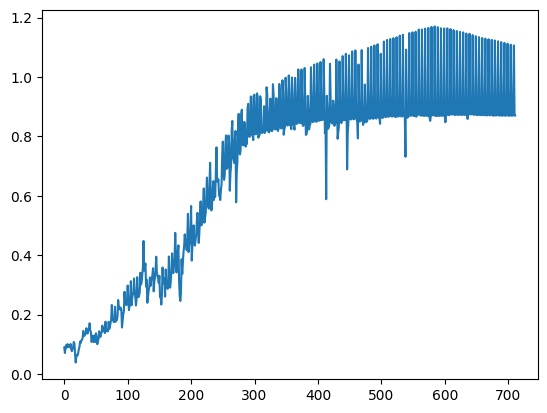

In [12]:
L = json.load(open(f"{output_dir}/sharpe_ratio_history.json"))
plt.plot(L)
plt.show()

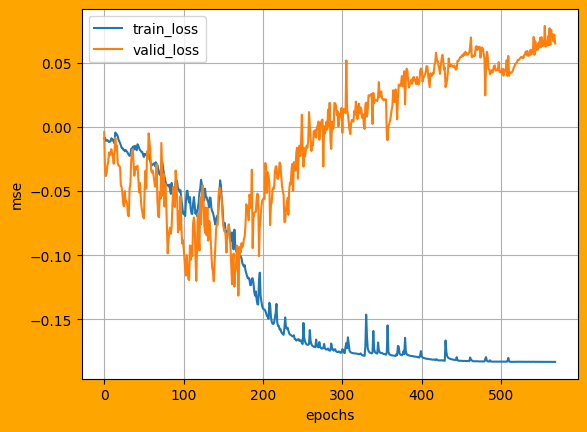

In [13]:
# check convergence
history = json.load(open(os.path.join(output_dir, "history.json")))
f = plt.figure()
f.set_facecolor("orange")
plt.plot(history['train_loss_list'], label='train_loss')
plt.plot(history['valid_loss_list'], label='valid_loss')
plt.xlabel("epochs")
plt.ylabel("mse")
plt.legend()
plt.grid()
plt.show()

### 4. Prediction
+ 4.1 testset
+ 4.2 (optional) metrics
+ 4.3 (optional) data improvement

In [ ]:
# load checkpoints and inference
# ckpt_path = os.path.join(output_dir, "best.pt")
# train_dataset_result = train_dataset.copy()
# trainloader = trainloader
# valid_dataset_result = valid_dataset.copy()
# validloader = validloader

# model = ToyTimeSeriesRegressionLSTM(
#         window_size,
#         num_input_features,
#         num_output_features,
#         hidden_size = 32
#     ).to(device)
# # model = ToyTransformerEncoder(
# #         window_size,
# #         num_input_features,
# #         num_output_features,
# #     ).to(device)
# model.load_state_dict(torch.load(ckpt_path))
# model.eval()
# loss_func = torch.nn.MSELoss(reduction="none")

# normalizer = Normalizer(pd.read_csv(f"{output_dir}/dataset_describe.csv", index_col=0))
# cols = ["open", "high", "low", "close", "volume"]

# for dataset_result, loader, name in [
#         (train_dataset_result, trainloader, "train"),
#         (valid_dataset_result, validloader, "valid")
#     ]:
#     prediction_list = []
#     loss_list = []
#     for x, y in loader:
#         with torch.no_grad():
#             pred = model(x)
#             loss = loss_func(pred, y)
#             prediction_list.append(pred.cpu().numpy())  # (B, 4)
#             loss_list.append(loss.cpu().numpy())  # (B, 4)
#     preds = np.concatenate(prediction_list)  # (N, num_output_features)

#     # denormalize
#     df_preds = pd.DataFrame(preds, columns=cols)
#     df_preds_denorm = normalizer.run(df_preds, denorm_map_dict)
#     df_result_x = normalizer.run(dataset_result[cols], denorm_map_dict)
#     df_result_y = normalizer.run(
#         dataset_result[[f"y_{col}" for col in cols]].rename(columns={f"y_{col}": col for col in cols}),
#         denorm_map_dict
#     ).rename(columns={col: f"y_{col}" for col in cols})
#     df_result = pd.concat([df_result_x, df_result_y], axis=1)
#     #print(df_result)
#     #print(df_preds_denorm)
#     #raise

#     preds_repeat = np.repeat(df_preds_denorm.to_numpy(), window_size, axis=0)  # (window_size * N, num_output_features)
#     loss = np.concatenate(loss_list)
#     loss_repeat = np.repeat(loss, window_size, axis=0)
#     df_result[[f"pred_{i}" for i in range(num_output_features)]] = preds_repeat
#     df_result[[f"loss_{i}" for i in range(num_output_features)]] = loss_repeat
#     df_result.to_csv(os.path.join(output_dir, f"{name}_df_result.csv"), index=False)
#     #print(df_result)
#     #raise